<a href="https://colab.research.google.com/github/Eric-Chung-0511/Learning-Record/blob/main/Data%20Science%20Projects/The%20Oxford-IIIT%20Pet%20Project/OxfordIIITPet_Project__Eric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
train_data = OxfordIIITPet(root='.', split='trainval', download=True)
test_data = OxfordIIITPet(root='.', split='test', download=True)

print(f'Train set size: {len(train_data)}, Test set size: {len(test_data)}')

100%|██████████| 791918971/791918971 [00:32<00:00, 24570420.71it/s]


Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 10764478.75it/s]


Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet
Train set size: 3680, Test set size: 3669


In [5]:
print(f'Number of classes: {len(train_data.classes)}')
print(f'Class names: {train_data.classes}')
print(f'Class to index mapping: {train_data.class_to_idx}')

Number of classes: 37
Class names: ['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair', 'Chihuahua', 'Egyptian Mau', 'English Cocker Spaniel', 'English Setter', 'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin', 'Keeshond', 'Leonberger', 'Maine Coon', 'Miniature Pinscher', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian Blue', 'Saint Bernard', 'Samoyed', 'Scottish Terrier', 'Shiba Inu', 'Siamese', 'Sphynx', 'Staffordshire Bull Terrier', 'Wheaten Terrier', 'Yorkshire Terrier']
Class to index mapping: {'Abyssinian': 0, 'American Bulldog': 1, 'American Pit Bull Terrier': 2, 'Basset Hound': 3, 'Beagle': 4, 'Bengal': 5, 'Birman': 6, 'Bombay': 7, 'Boxer': 8, 'British Shorthair': 9, 'Chihuahua': 10, 'Egyptian Mau': 11, 'English Cocker Spaniel': 12, 'English Setter': 13, 'German Shorthaired': 14, 'Great Pyrenees': 15, 'Havanese': 16, 'Japanese Chin': 17, 'Keesh

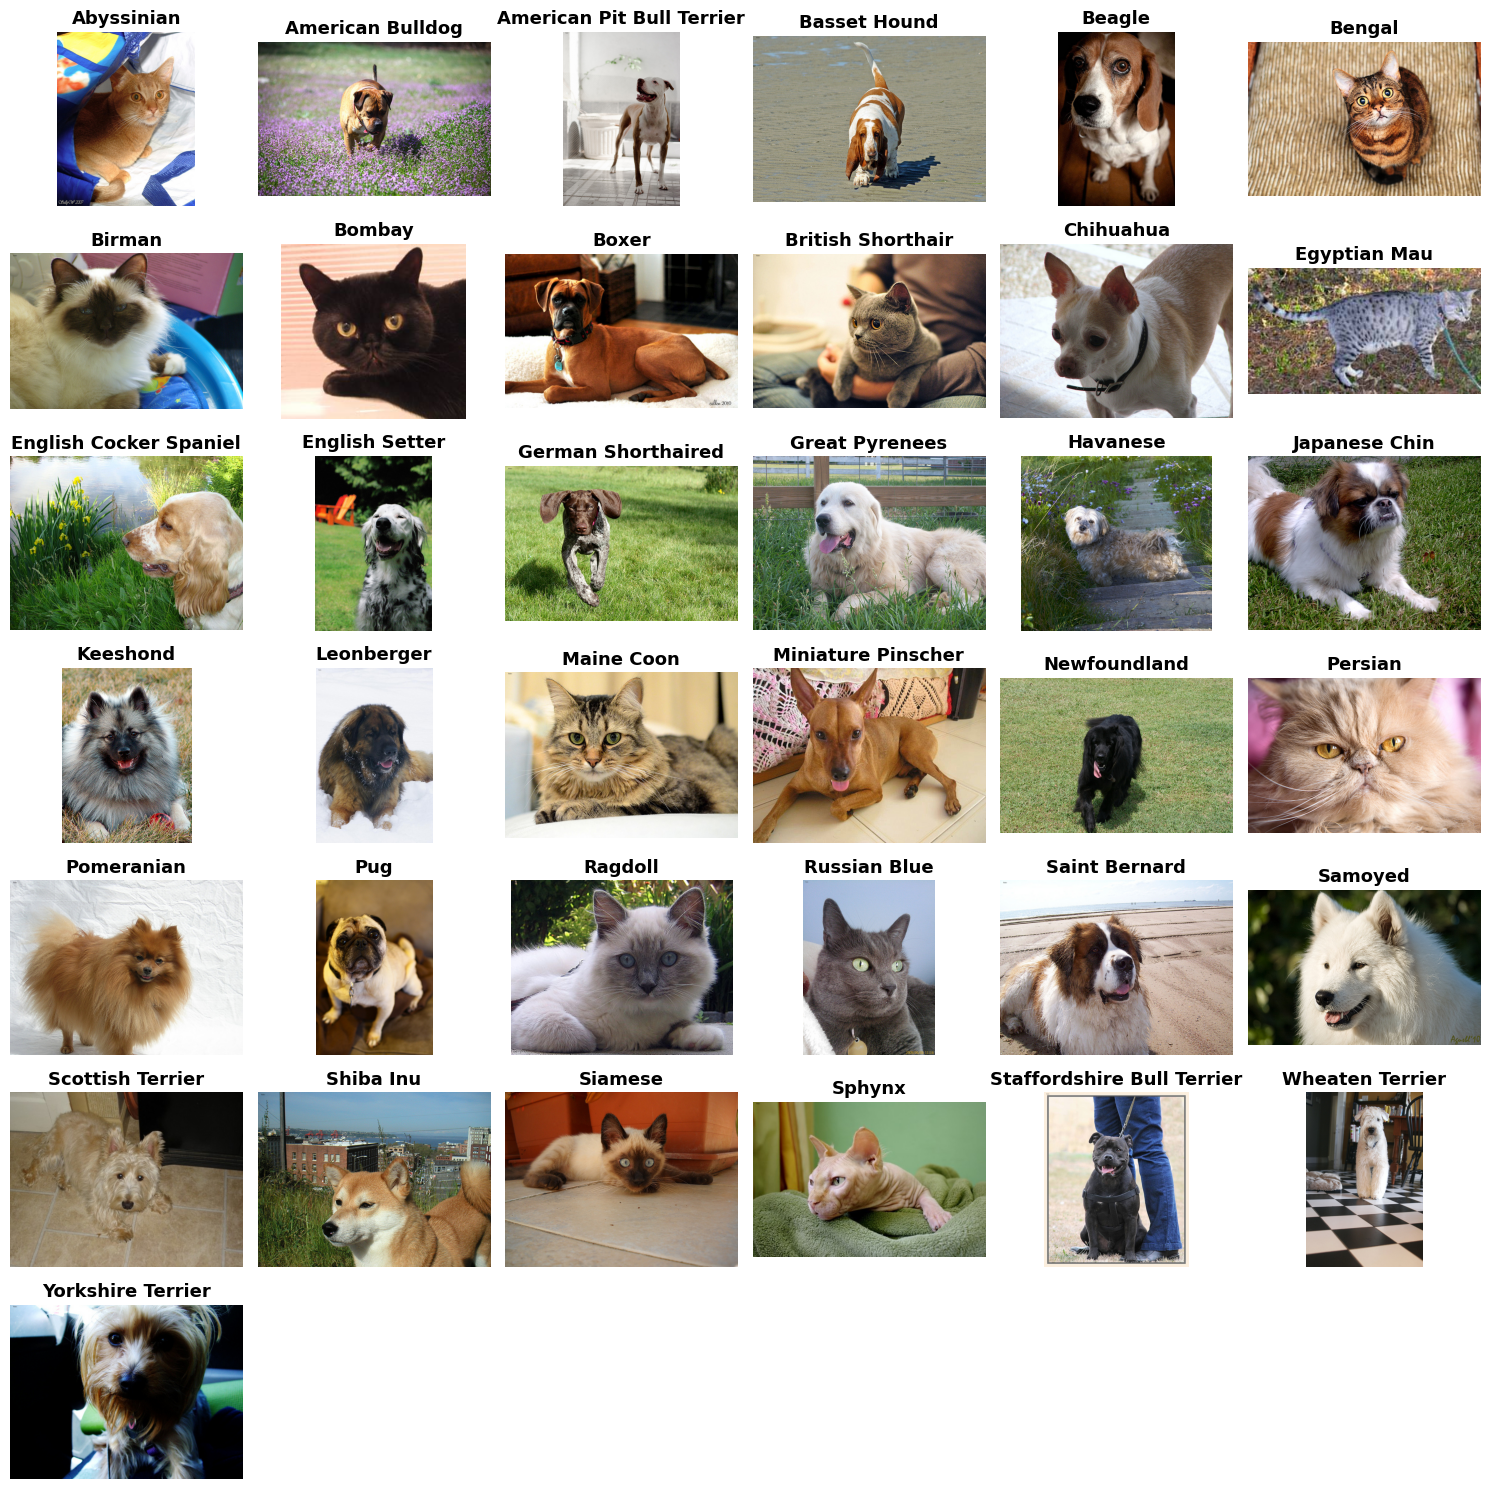

In [6]:
class_names = train_data.classes
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

plt.figure(figsize=(15, 15))

for i, class_name in enumerate(class_names): # Loop through each class (category) by its name
    for img, label in train_data: # For each image in the dataset, check if it matches the current class
        if label == class_to_idx[class_name]:
            plt.subplot(7, 6, i+1)
            plt.imshow(np.array(img))
            plt.axis('off')
            plt.title(class_name, fontsize=13, weight='bold')
            break

plt.tight_layout()
plt.show()

In [17]:
# Basic transformation for model usage
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# 確保正確應用了 transforms
train_data = OxfordIIITPet(root='.', split='trainval', download=True, transform=transform)
test_data = OxfordIIITPet(root='.', split='test', download=True, transform=transform)

# Augmentation for training data
aug_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(10),
                                    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
                                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                                    transforms.RandomErasing(p=0.5)])

In [18]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
        train_data,
        test_data,
        transform: transforms.Compose,
        batch_size: int,
        num_workers: int = 0,
        use_augmentation: bool = False,
        aug_transform: transforms.Compose = None
):
    """Create training and testing DataLoaders with optional data augmentation.

    Args:
        train_data: A torchvision dataset instance for training data.
        test_data: A torchvision dataset instance for testing data.
        transform: Basic torchvision transforms to perform on both training and testing data.
        batch_size: Number of samples per batch in each of the DataLoaders.
        num_workers: An integer for number of workers per DataLoader.
        use_augmentation: A boolean to apply augmentation transforms to training data.
        aug_transform: Additional torchvision transforms for augmentation.

    Returns:
        A tuple of (train_dataloader, test_dataloader, class_names).
        Where class_names is a list of the target classes.
    """
    # Apply basic transform to datasets
    train_data.transform = transform
    test_data.transform = transform

    # Apply augmentation if specified (only for training data)
    if use_augmentation and aug_transform:
        train_data.transform = transforms.Compose([aug_transform, transform])
    else:
        train_data.transform = transform

    # Get class names
    class_names = train_data.classes

    # Create DataLoaders
    train_dataloader = DataLoader(train_data,
                                  batch_size=batch_size,
                                  num_workers=NUM_WORKERS,
                                  shuffle=True,
                                  pin_memory=True)

    test_dataloader = DataLoader(test_data,
                                 batch_size=batch_size,
                                 num_workers=NUM_WORKERS,
                                 shuffle=False,
                                 pin_memory=True)

    return train_dataloader, test_dataloader, class_names

In [19]:
train_dataloader, test_dataloader, class_names = create_dataloaders(train_data=train_data,
                                                                    test_data=test_data,
                                                                    transform=transform,
                                                                    batch_size=32,
                                                                    use_augmentation=True,
                                                                    aug_transform=aug_transform)

num_classes = len(class_names)

In [10]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 20.9 MB/s eta 0:00:00


In [11]:
!pip install torchinfo

In [12]:
from torch import nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from torchinfo import summary
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

In [13]:
import torchmetrics
from torchmetrics import Accuracy, Precision, Recall, F1Score
from typing import Dict, List, Tuple
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.auto import tqdm

class Trainer:
    """
    A class to encapsulate the training, testing, and evaluation of a PyTorch model.

    Attributes:
        model (torch.nn.Module): The PyTorch model to be trained and evaluated.
        train_dataloader (torch.utils.data.DataLoader): DataLoader for training data.
        test_dataloader (torch.utils.data.DataLoader): DataLoader for testing data.
        optimizer (torch.optim.Optimizer): Optimizer used to update model weights.
        loss_fn (torch.nn.Module): Loss function used to calculate the error.
        device (torch.device): The device (CPU or GPU) on which computations are performed.
        num_classes (int): Number of classes in the classification task.
        scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Learning rate scheduler (default is None).
        early_stopping_patience (int, optional): Number of epochs with no improvement after which training will be stopped (default is None).
    """

    def __init__(self,
                 model: torch.nn.Module,
                 train_dataloader: torch.utils.data.DataLoader,
                 test_dataloader: torch.utils.data.DataLoader,
                 optimizer: torch.optim.Optimizer,
                 loss_fn: torch.nn.Module,
                 device: torch.device,
                 num_classes: int,
                 scheduler: torch.optim.lr_scheduler._LRScheduler = None,
                 early_stopping_patience: int = None):
        """
        Initializes the Trainer class with the given model, data loaders, optimizer, loss function, and other training parameters.

        Args:
            model (torch.nn.Module): The PyTorch model to be trained and tested.
            train_dataloader (torch.utils.data.DataLoader): DataLoader instance for training data.
            test_dataloader (torch.utils.data.DataLoader): DataLoader instance for testing data.
            optimizer (torch.optim.Optimizer): Optimizer to update the model's parameters.
            loss_fn (torch.nn.Module): Loss function to minimize during training.
            device (torch.device): The device to perform computation on (e.g., 'cuda' or 'cpu').
            num_classes (int): Number of classes in the classification task.
            scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Scheduler to adjust the learning rate during training (default is None).
            early_stopping_patience (int, optional): Number of epochs with no improvement after which training stops (default is None).
        """
        self.model = model.to(device)
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device
        self.num_classes = num_classes
        self.scheduler = scheduler
        self.early_stopping_patience = early_stopping_patience

        # Initialize metrics using torchmetrics
        self.metrics = {
            "accuracy": Accuracy(task='multiclass', num_classes=num_classes).to(device),
            "precision": Precision(task='multiclass', num_classes=num_classes).to(device),
            "recall": Recall(task='multiclass', num_classes=num_classes).to(device),
            "f1": F1Score(task='multiclass', num_classes=num_classes).to(device)
        }

    def train_step(self) -> Tuple[float, Dict[str, float]]:
        """
        Trains the model for a single epoch using the training dataloader.

        Returns:
            Tuple[float, Dict[str, float]]: Returns the average training loss and a dictionary of computed metrics.
        """
        self.model.train()  # Set the model to training mode
        train_loss = 0
        metric_results = {name: 0 for name in self.metrics.keys()}

        # Iterate over batches of data
        for X, y in self.train_dataloader:
            X, y = X.to(self.device), y.to(self.device)
            y_pred = self.model(X)
            if hasattr(y_pred, 'logits'):
                y_pred = y_pred.logits # # extract logits
            loss = self.loss_fn(y_pred, y)
            train_loss += loss.item()

            # Backpropagation and optimization
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Calculate metrics for this batch
            y_pred_class = torch.argmax(y_pred, dim=1)
            for name, metric in self.metrics.items():
                metric_results[name] += metric(y_pred_class, y).item()

        # Average the loss and metrics over all batches
        train_loss /= len(self.train_dataloader)
        metric_results = {name: total / len(self.train_dataloader) for name, total in metric_results.items()}
        return train_loss, metric_results

    def test_step(self) -> Tuple[float, Dict[str, float]]:
        """
        Tests the model for a single epoch using the testing dataloader.

        Returns:
            Tuple[float, Dict[str, float]]: Returns the average testing loss and a dictionary of computed metrics.
        """
        self.model.eval()  # Set the model to evaluation mode
        test_loss = 0
        metric_results = {name: 0 for name in self.metrics.keys()}

        # No gradients needed for evaluation
        with torch.inference_mode():
            for X, y in self.test_dataloader:
                X, y = X.to(self.device), y.to(self.device)
                y_pred = self.model(X)
                if hasattr(y_pred, 'logits'):
                    y_pred = y_pred.logits # extract logits
                loss = self.loss_fn(y_pred, y)
                test_loss += loss.item()

                # Calculate metrics for this batch
                y_pred_class = torch.argmax(y_pred, dim=1)
                for name, metric in self.metrics.items():
                    metric_results[name] += metric(y_pred_class, y).item()

        # Average the loss and metrics over all batches
        test_loss /= len(self.test_dataloader)
        metric_results = {name: total / len(self.test_dataloader) for name, total in metric_results.items()}
        return test_loss, metric_results

    def train(self, epochs: int) -> Dict[str, List[float]]:
        """
        Trains the model over a specified number of epochs, with optional learning rate scheduling and early stopping.

        Args:
            epochs (int): Number of epochs to train the model for.

        Returns:
            Dict[str, List[float]]: A dictionary containing the training and testing loss and metrics for each epoch.
        """
        results = {"train_loss": [],
                   "train_acc": [],
                   "train_precision": [],
                   "train_recall": [],
                   "train_f1": [],
                   "test_loss": [],
                   "test_acc": [],
                   "test_precision": [],
                   "test_recall": [],
                   "test_f1": []}

        best_loss = float('inf')
        epochs_without_improvement = 0

        # Iterate over each epoch
        for epoch in tqdm(range(epochs)):
            train_loss, train_metrics = self.train_step()
            test_loss, test_metrics = self.test_step()

            # Print the metrics for this epoch
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"train_acc: {train_metrics['accuracy']:.4f} | "
                f"train_precision: {train_metrics['precision']:.4f} | "
                f"train_recall: {train_metrics['recall']:.4f} | "
                f"train_f1: {train_metrics['f1']:.4f} | "
                f"test_loss: {test_loss:.4f} | "
                f"test_acc: {test_metrics['accuracy']:.4f} | "
                f"test_precision: {test_metrics['precision']:.4f} | "
                f"test_recall: {test_metrics['recall']:.4f} | "
                f"test_f1: {test_metrics['f1']:.4f}"
            )

            # Store the metrics in the results dictionary
            results["train_loss"].append(train_loss)
            results["train_acc"].append(train_metrics['accuracy'])
            results["train_precision"].append(train_metrics['precision'])
            results["train_recall"].append(train_metrics['recall'])
            results["train_f1"].append(train_metrics['f1'])
            results["test_loss"].append(test_loss)
            results["test_acc"].append(test_metrics['accuracy'])
            results["test_precision"].append(test_metrics['precision'])
            results["test_recall"].append(test_metrics['recall'])
            results["test_f1"].append(test_metrics['f1'])

            # Update the learning rate if scheduler is provided
            if self.scheduler:
                self.scheduler.step(test_loss)

            # Implement early stopping
            if self.early_stopping_patience:
                if test_loss < best_loss:
                    best_loss = test_loss
                    epochs_without_improvement = 0
                else:
                    epochs_without_improvement += 1
                    if epochs_without_improvement >= self.early_stopping_patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break

        return results


    def classification_report(self, class_names: List[str]) -> None:
        """
        Generates and prints a classification report based on the test dataset.

        Args:
            class_names (List[str]): List of class names for the classification report.
        """
        self.model.eval()  # Set the model to evaluation mode
        y_true = []
        y_pred = []

        # Perform inference on the test set
        with torch.inference_mode():
            for X, y in self.test_dataloader:
                X, y = X.to(self.device), y.to(self.device)
                preds = self.model(X)

                # Store the true labels and the predicted labels
                y_true.extend(y.cpu().numpy())
                y_pred.extend(torch.argmax(preds, dim=1).cpu().numpy())

        # Generate and print the classification report
        print(classification_report(y_true, y_pred, target_names=class_names))

## ResNet50 Modeling

In [14]:
resnet50_weight = ResNet50_Weights.DEFAULT
resnet50_model = models.resnet50(weights=resnet50_weight).to(device)

resnet50_model.fc = torch.nn.Linear(in_features=resnet50_model.fc.in_features, out_features=num_classes)

summary(model=resnet50_model,
        input_size=(32, 3, 224, 224),  # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 114MB/s]


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 37]             --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

## Fine Tuning ResNet50

In [15]:
for param in resnet50_model.parameters():
    param.requires_grad = False

# unfrozen last 4 layers, layer4 is the last Conv2d layer
for param in resnet50_model.layer4.parameters():
    param.requires_grad = True

In [20]:
optimizer = optim.AdamW(resnet50_model.parameters(), lr=0.001, weight_decay=1e-4)
# optimizer = torch.optim.Adam(resnet50_model.parameters(), lr=0.001, weight_decay=1e-4)

loss_fn = torch.nn.CrossEntropyLoss()

scheduler = OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_dataloader), epochs=20)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

trainer = Trainer(model=resnet50_model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  num_classes=num_classes,
                  scheduler=scheduler,
                  device=device,
                  early_stopping_patience=5)

resnet50_results = trainer.train(epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.2247 | train_acc: 0.3459 | train_precision: 0.3459 | train_recall: 0.3459 | train_f1: 0.3459 | test_loss: 2.2185 | test_acc: 0.7970 | test_precision: 0.7970 | test_recall: 0.7970 | test_f1: 0.7970


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 2 | train_loss: 1.5784 | train_acc: 0.8668 | train_precision: 0.8668 | train_recall: 0.8668 | train_f1: 0.8668 | test_loss: 0.7478 | test_acc: 0.9007 | test_precision: 0.9007 | test_recall: 0.9007 | test_f1: 0.9007
Epoch: 3 | train_loss: 0.6534 | train_acc: 0.9293 | train_precision: 0.9293 | train_recall: 0.9293 | train_f1: 0.9293 | test_loss: 0.4518 | test_acc: 0.9156 | test_precision: 0.9156 | test_recall: 0.9156 | test_f1: 0.9156
Epoch: 4 | train_loss: 0.3612 | train_acc: 0.9489 | train_precision: 0.9489 | train_recall: 0.9489 | train_f1: 0.9489 | test_loss: 0.3449 | test_acc: 0.9216 | test_precision: 0.9216 | test_recall: 0.9216 | test_f1: 0.9216
Epoch: 5 | train_loss: 0.2171 | train_acc: 0.9685 | train_precision: 0.9685 | train_recall: 0.9685 | train_f1: 0.9685 | test_loss: 0.3172 | test_acc: 0.9205 | test_precision: 0.9205 | test_recall: 0.9205 | test_f1: 0.9205
Epoch: 6 | train_loss: 0.1463 | train_acc: 0.9837 | train_precision: 0.9837 | train_recall: 0.9837 | train_f1: 0

In [23]:
# Print the classification report
trainer.classification_report(class_names=class_names)

                            precision    recall  f1-score   support

                Abyssinian       0.92      0.90      0.91        98
          American Bulldog       0.73      0.91      0.81       100
 American Pit Bull Terrier       0.91      0.48      0.63       100
              Basset Hound       0.96      0.92      0.94       100
                    Beagle       0.87      0.94      0.90       100
                    Bengal       0.76      0.94      0.84       100
                    Birman       0.79      0.83      0.81       100
                    Bombay       0.93      0.98      0.96        88
                     Boxer       0.87      0.94      0.90        99
         British Shorthair       0.94      0.89      0.91       100
                 Chihuahua       0.93      0.92      0.92       100
              Egyptian Mau       0.94      0.84      0.89        97
    English Cocker Spaniel       0.99      0.97      0.98       100
            English Setter       0.99      0.97

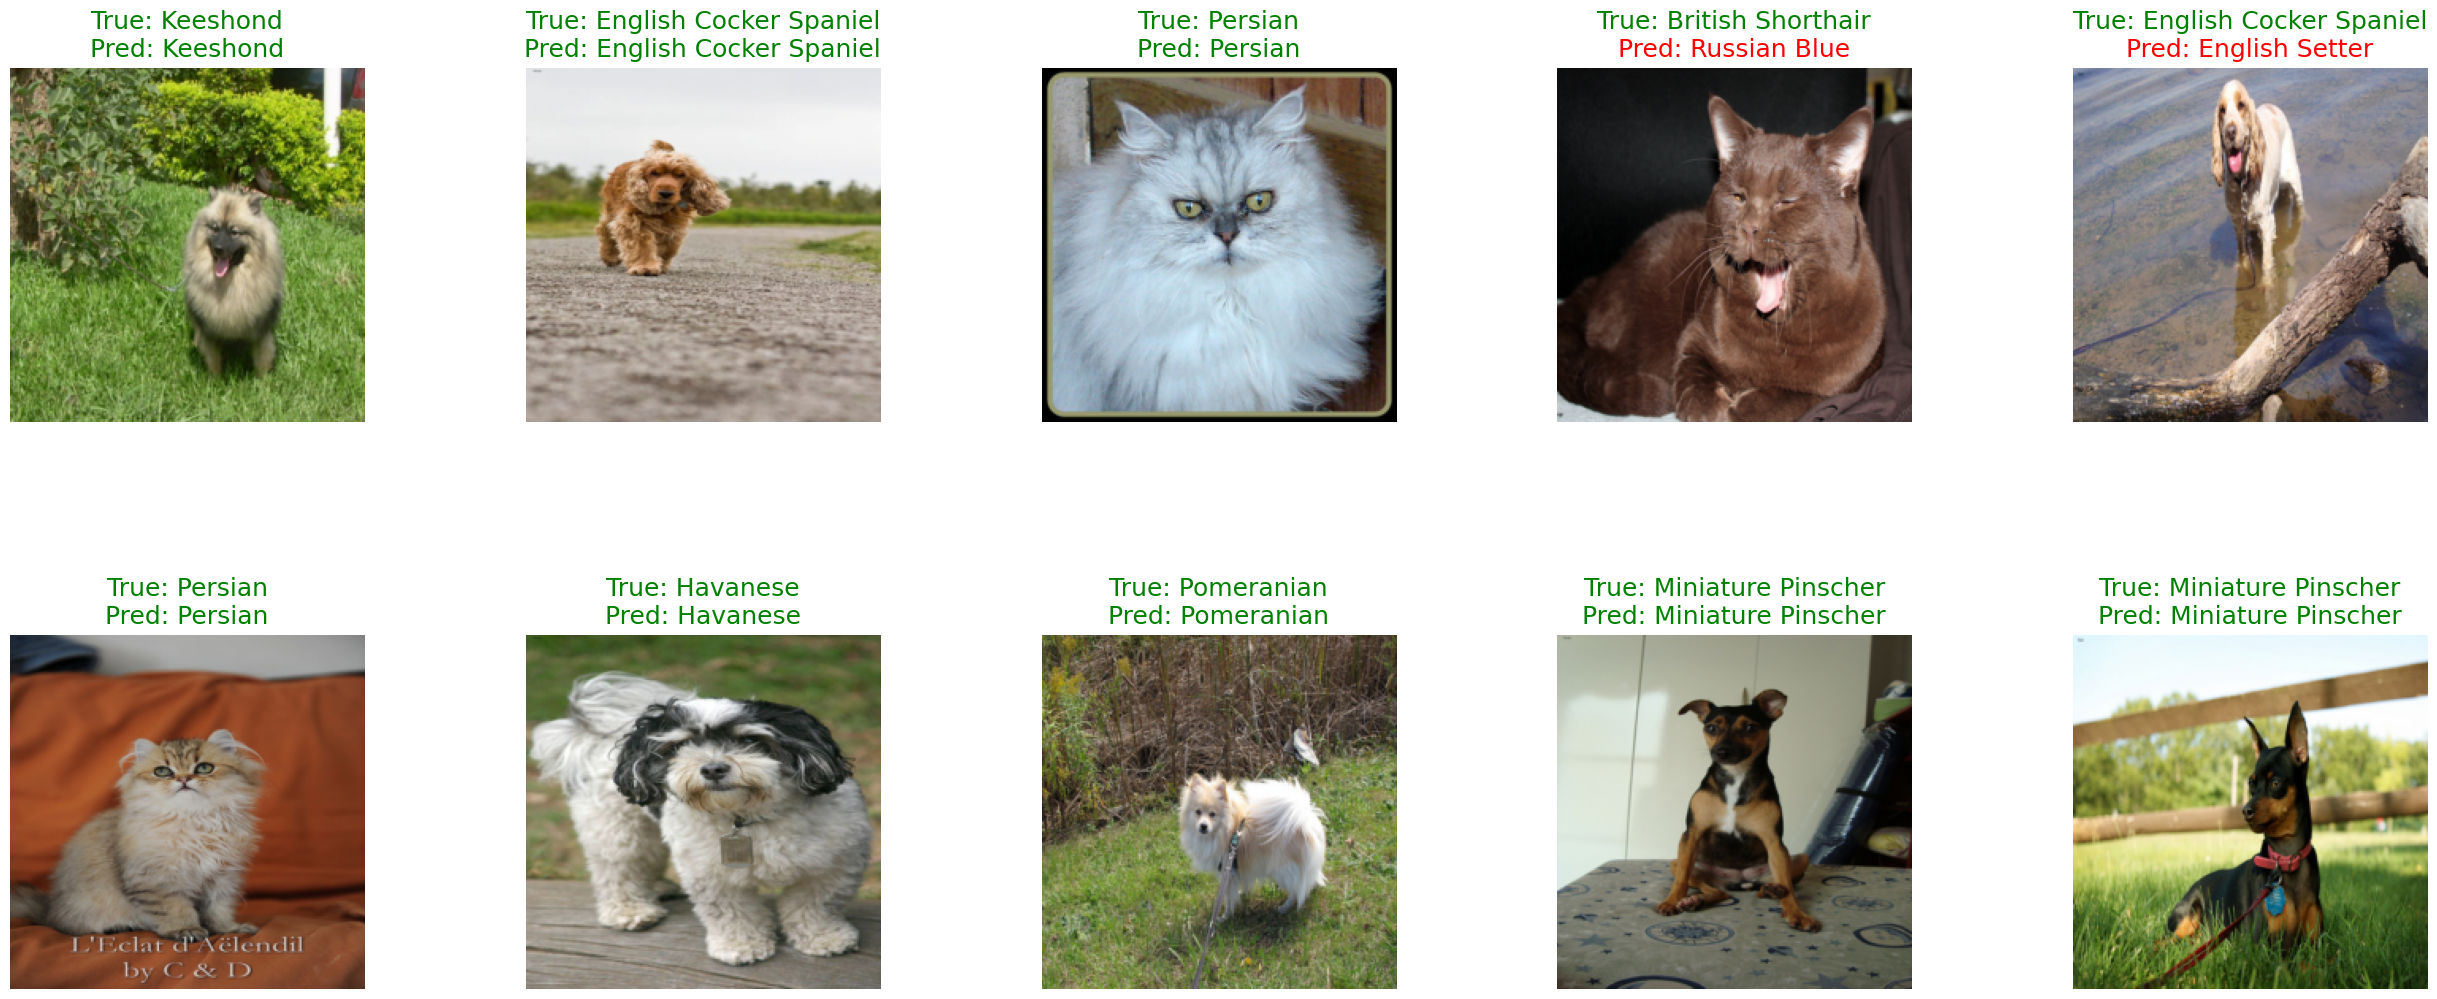

In [36]:
import random

plt.figure(figsize=(25, 10))

num_samples = 10

for i in range(num_samples):
    idx = random.randint(0, len(test_data)-1)
    img, label = test_data[idx]

    # model inference
    img_tensor = img.unsqueeze(0).to(device)
    with torch.no_grad():
        output = resnet50_model(img_tensor)
        pred_label = output.argmax(dim=1).item()

    # show image
    img_np = img.permute(1, 2, 0).cpu().numpy() # need to be matplotlib format
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    ax = plt.subplot(2, 5, i+1)
    plt.imshow(img_np)
    plt.axis('off')

    # if the predict and test is right, use green word, otherwise use red word
    pred_color = 'red' if pred_label != label else 'green'

    # adjust the texe above the image
    ax.text(0.5, 1.10, f"True: {class_names[label]}",
            color='green', ha='center', va='bottom', transform=ax.transAxes, fontsize=18)
    ax.text(0.5, 1.02, f"Pred: {class_names[pred_label]}",
            color=pred_color, ha='center', va='bottom', transform=ax.transAxes, fontsize=18)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.6)
plt.show()

## EfficientNetB3 Modeling

In [42]:
efficientnetb3_weights = models.EfficientNet_B3_Weights.DEFAULT
efficientnetb3_model = models.efficientnet_b3(weights=efficientnetb3_weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 125MB/s]


In [44]:
for name, layer in efficientnetb3_model.named_children():
    print(f"Layer: {name}, Type: {layer}")

Layer: features, Type: Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(40, 24, kernel_siz

In [45]:
efficientnetb3_model.classifier[1] = torch.nn.Linear(in_features=1536, out_features=num_classes)

summary(model=efficientnetb3_model,
        input_size=(32, 3, 224, 224),  # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 37]             --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1536, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 40, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 40, 112, 112]   1,080                True
│    │    └─BatchNorm2d (1)                                  [32, 40, 112, 112]   [32, 40, 112, 112]   80                   True
│    │    └─SiLU (2)                                         [32, 40, 112, 112]   [32, 40, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 40, 112, 112]   [32, 24, 112

In [46]:
for param in efficientnetb3_model.parameters():
    param.requires_grad = False

# unfrozen the last two blocks
for param in efficientnetb3_model.features[-2].parameters():
    param.requires_grad = True

# unfrozen the classifier
for param in efficientnetb3_model.classifier.parameters():
    param.requires_grad = True

In [47]:
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, efficientnetb3_model.parameters()), lr=0.001, weight_decay=1e-4)
# optimizer = torch.optim.Adam(resnet50_model.parameters(), lr=0.001, weight_decay=1e-4)

loss_fn = torch.nn.CrossEntropyLoss()

scheduler = OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_dataloader), epochs=20)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

trainer = Trainer(model=efficientnetb3_model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  num_classes=num_classes,
                  scheduler=scheduler,
                  device=device,
                  early_stopping_patience=5)

efficientnetb3_results = trainer.train(epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.4933 | train_acc: 0.1247 | train_precision: 0.1247 | train_recall: 0.1247 | train_f1: 0.1247 | test_loss: 3.3126 | test_acc: 0.4048 | test_precision: 0.4048 | test_recall: 0.4048 | test_f1: 0.4048


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 2 | train_loss: 3.0871 | train_acc: 0.4389 | train_precision: 0.4389 | train_recall: 0.4389 | train_f1: 0.4389 | test_loss: 2.7642 | test_acc: 0.6725 | test_precision: 0.6725 | test_recall: 0.6725 | test_f1: 0.6725
Epoch: 3 | train_loss: 2.4537 | train_acc: 0.6497 | train_precision: 0.6497 | train_recall: 0.6497 | train_f1: 0.6497 | test_loss: 2.0089 | test_acc: 0.7776 | test_precision: 0.7776 | test_recall: 0.7776 | test_f1: 0.7776
Epoch: 4 | train_loss: 1.8271 | train_acc: 0.7421 | train_precision: 0.7421 | train_recall: 0.7421 | train_f1: 0.7421 | test_loss: 1.3803 | test_acc: 0.8240 | test_precision: 0.8240 | test_recall: 0.8240 | test_f1: 0.8240
Epoch: 5 | train_loss: 1.3907 | train_acc: 0.7815 | train_precision: 0.7815 | train_recall: 0.7815 | train_f1: 0.7815 | test_loss: 1.0543 | test_acc: 0.8403 | test_precision: 0.8403 | test_recall: 0.8403 | test_f1: 0.8403
Epoch: 6 | train_loss: 1.1350 | train_acc: 0.8060 | train_precision: 0.8060 | train_recall: 0.8060 | train_f1: 0

In [48]:
# Print the classification report
trainer.classification_report(class_names=class_names)

                            precision    recall  f1-score   support

                Abyssinian       0.81      0.90      0.85        98
          American Bulldog       0.82      0.89      0.85       100
 American Pit Bull Terrier       0.77      0.49      0.60       100
              Basset Hound       0.93      0.88      0.90       100
                    Beagle       0.86      0.90      0.88       100
                    Bengal       0.74      0.86      0.79       100
                    Birman       0.84      0.77      0.80       100
                    Bombay       0.86      0.93      0.90        88
                     Boxer       0.80      0.87      0.83        99
         British Shorthair       0.83      0.78      0.80       100
                 Chihuahua       0.95      0.79      0.86       100
              Egyptian Mau       0.87      0.86      0.86        97
    English Cocker Spaniel       0.91      0.93      0.92       100
            English Setter       0.96      0.91

In [49]:
def visualize_predictions(model, test_data, class_names, device, num_samples=10):
    """
    Visualize random predictions made by the model on test data.

    Parameters:
    - model: The trained model for inference
    - test_data: The test dataset
    - class_names: List of class names for predictions
    - device: Device to perform inference ('cpu' or 'cuda')
    - num_samples: Number of samples to visualize (default is 10)
    """
    plt.figure(figsize=(25, 10))

    for i in range(num_samples):
        # random pick samples
        idx = random.randint(0, len(test_data)-1)
        img, label = test_data[idx]

        # model inference
        img_tensor = img.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(img_tensor)
            pred_label = output.argmax(dim=1).item()

        img_np = img.permute(1, 2, 0).cpu().numpy()  # turn into matplotlib format
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean  # reverse the standardization
        img_np = np.clip(img_np, 0, 1)  # limit to the range(0, 1)

        # show image
        ax = plt.subplot(2, 5, i+1)
        plt.imshow(img_np)
        plt.axis('off')

        # if the prediction is wrong use red word, otherwise use green word
        pred_color = 'red' if pred_label != label else 'green'

        # adjust the text above the image
        ax.text(0.5, 1.10, f"True: {class_names[label]}",
                color='green', ha='center', va='bottom', transform=ax.transAxes, fontsize=18)
        ax.text(0.5, 1.02, f"Pred: {class_names[pred_label]}",
                color=pred_color, ha='center', va='bottom', transform=ax.transAxes, fontsize=18)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.6)
    plt.show()

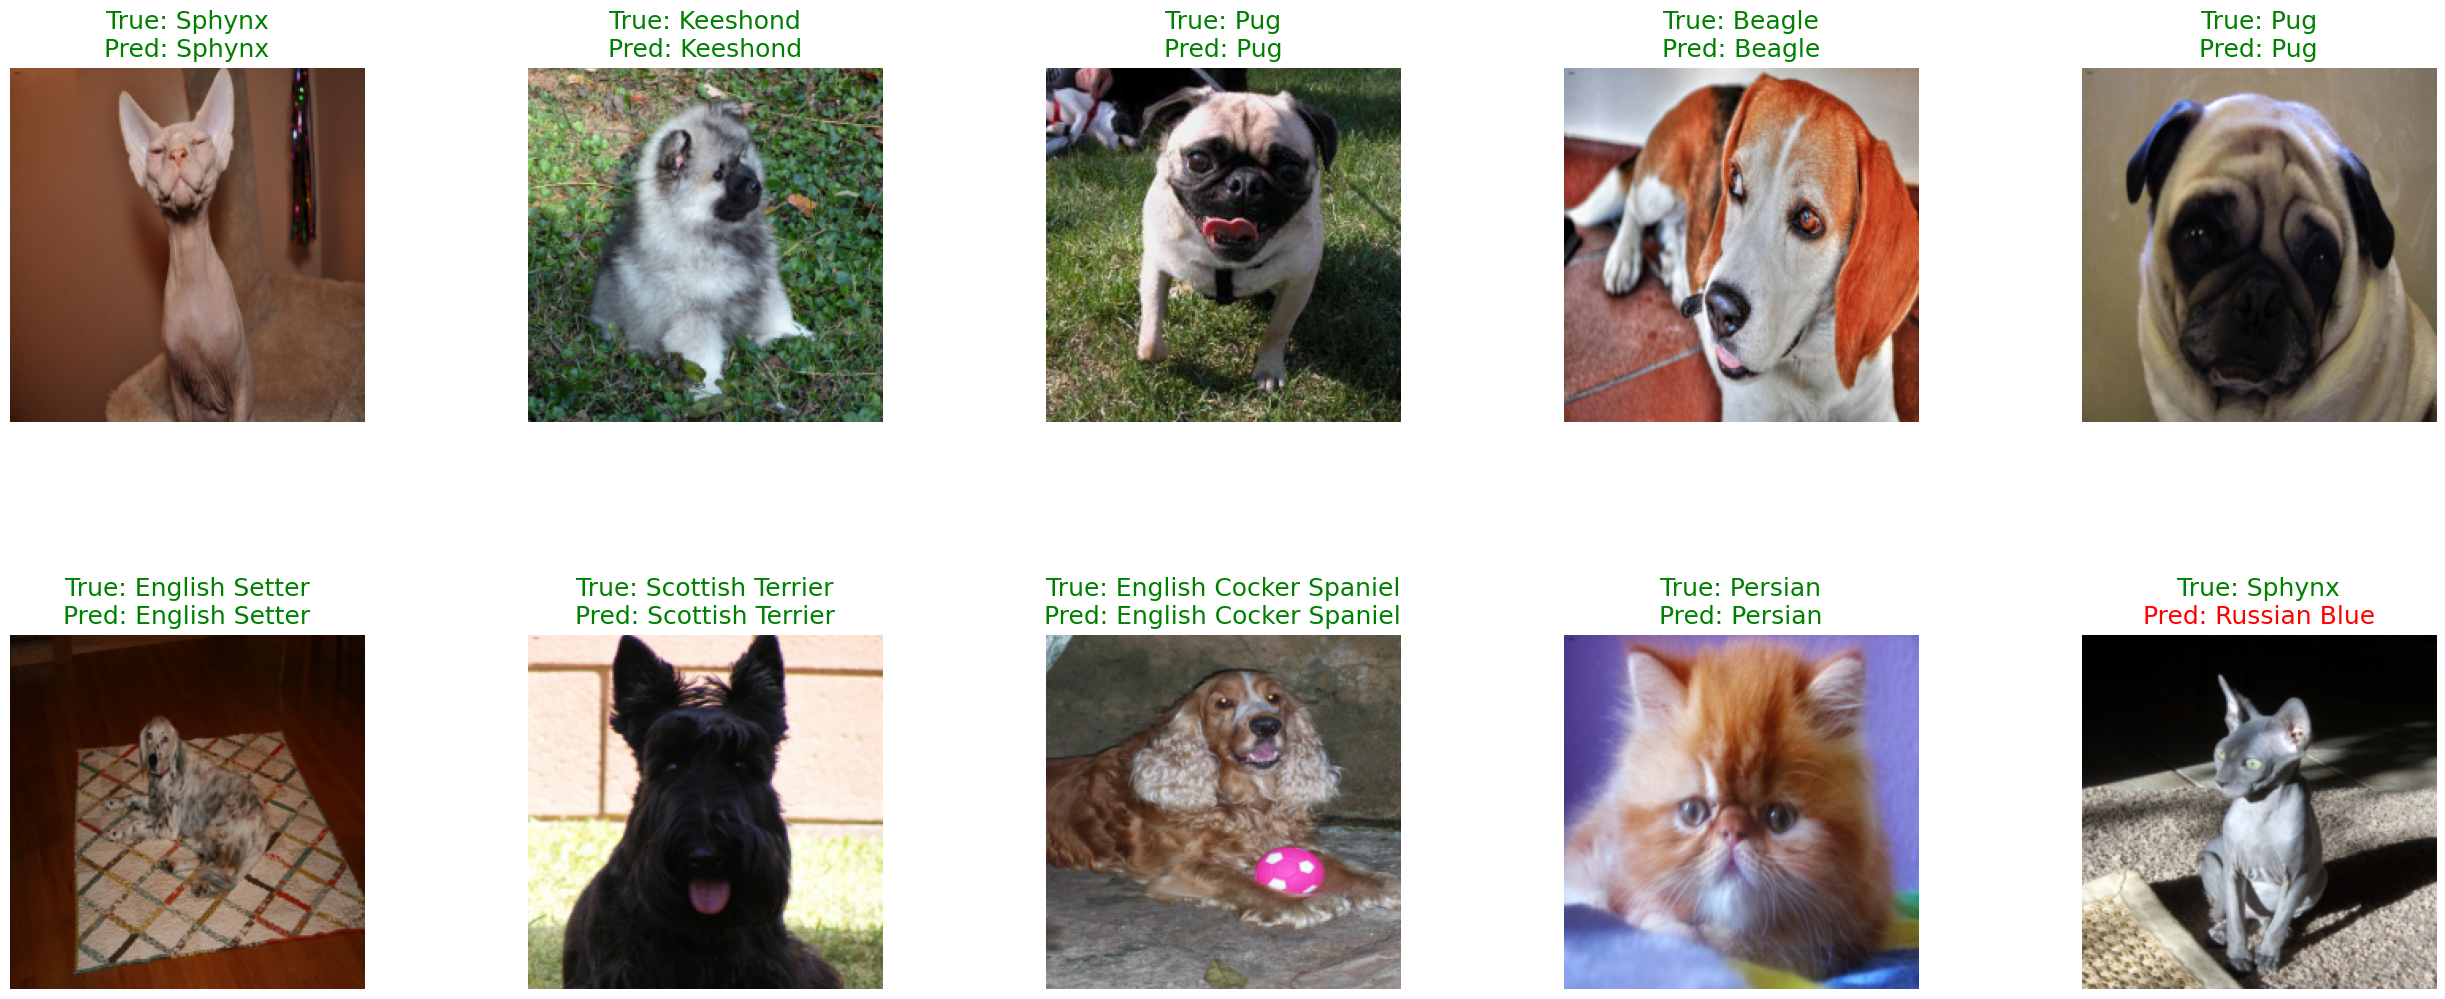

In [50]:
visualize_predictions(efficientnetb3_model, test_data, class_names, device, num_samples=10)

In [24]:
# save model weights
torch.save(resnet50_model.state_dict(), 'resnet50_model_weights.pth')

In [ ]:
# load model
# resnet50_model.load_state_dict(torch.load('resnet50_model_weights.pth'))
# resnet50_model.eval()  # set the eval mode